<a href="https://colab.research.google.com/github/karlbuscheck/firesat-lite/blob/main/firesat_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FireSat-Lite

### Project Overview

Inspired by Google's [FireSat](https://blog.google/technology/research/first-firesat-images/), an AI-powered constellation of satellites that will be able to detect any wildfire on Earth greater than 5x5 meters within 20 minutes, this project builds and compares deep learning architectures to detect wildfires using the 43K image [FireEye](https://www.kaggle.com/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset) dataset.

To ensure rigorous and unbiased results, the entire modeling process adheres to strict machine learning best practices, including using global random seeds for reproducibility, dedicated train/validation/test splits, and strategic EarlyStopping to combat overfitting. The final, best-performing model achieved a highly competitive and unbiased 95.30% Test Accuracy.

The dataset consists of images, distributed across three balanced classes:

1. Fire

2. Smoke

3. Non-Fire

---

### Project Roadmap

- **Load, preprocess and explore the dataset**: Prepare images for modeling, ensuring a clean and fixed train/validation/test split for a fair final evaluation.

- **Build and stabilize the baseline model**: A fully connected Deep Neural Network (DNN) used as a rigorous benchmark, trained with EarlyStopping.

- **Train a collection of Convolutional Neural Networks (CNNs)**: Leveraging spatial patterns, this phase systematically tests advanced regularization techniques, including Data Augmentation and strategic Dropout, to achieve the optimal, most generalizable model architecture.

---

### Key Highlight

Our final, best-performing model (CNN with strategic Dropout) achieved a highly competitive and unbiased **95.30% Test Accuracy** on the unseen test set, proving that strong regularization is critical for generalizing on this task.

**Next up**: Future work would explore **transfer learning** with pre-trained models like MobileNetV3 to tackle larger, higher-resolution datasets.

## Load, preprocess and explore the dataset

Let's get our data ready for modeling. Spolier alert: there's a lot to be done. We need to mount Google Drive, handle image and batch sizes, use ImageDataGenerator to stream the data into bathces and split the training/validation and test sets.

Once the data is local, we'll use `ImageDataGenerator` to handle image resizing, create batches, and split the data into our final training, validation, and test sets.

It all leads to quite the realization: **colors are simply numbers**.

In [ ]:
# Mount Drive and COPY the folders
from google.colab import drive
drive.mount('/content/drive')

# Create a destination folder on the fast local disk
!mkdir -p /content/firesat_data

# Copy the train and test folders; This is the SLOW step
print("Starting file copy... this will take 10-30 minutes.")
!cp -r "/content/drive/MyDrive/Colab Notebooks/fire_sat_lite/firesat-dataset/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train" "/content/firesat_data/"
!cp -r "/content/drive/MyDrive/Colab Notebooks/fire_sat_lite/firesat-dataset/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test" "/content/firesat_data/"
print("File copy complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting file copy... this will take 10-30 minutes.
File copy complete!


In [ ]:
# Start with the imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Set global seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Define the dataset base path
BASE = "/content/drive/My Drive/Colab Notebooks/fire_sat_lite/firesat-dataset/3/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET"

# Set the fast paths
train_dir = "/content/firesat_data/train"
test_dir = "/content/firesat_data/test"

# Make sure the folders exist
print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))

# Set image size and batch size # Note: Image size means every image is resized to 64 pixels high by 64 pixels wide -- we are starting
# relatively small because the dataset is so larger; and batch size means the model processes 32 images at once before updating weights
IMG_SIZE = (64, 64)
BATCH    = 32

# Create ImageDataGenerator and split the training set into training/validation
# Note: The ImageDataGenerator loads images in batches, rescalse pixels, and feeds them to the model on the fly
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Load the training images
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

# Load the validation images
val_data = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)

# Load the test images
# Note: No split required -- just rescale
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

Train dir exists: True
Test dir exists: True
Found 29159 images belonging to 3 classes.
Found 3239 images belonging to 3 classes.
Found 10500 images belonging to 3 classes.


As a quick refresher, let's take a quick look at our three classes.

In [ ]:
# Check class-to-index mapping -- this shows which class label maps to which integer
train_data.class_indices

{'Smoke': 0, 'fire': 1, 'non fire': 2}

In [ ]:
# Grab one batch of images and labels from each generator
x_train, y_train = next(iter(train_data))
x_val,   y_val   = next(iter(val_data))
x_test,  y_test  = next(iter(test_data))

# Display the shape of each batch to confirm dimensions
print(x_train.shape, y_train.shape)
print(x_val.shape,   y_val.shape)
print(x_test.shape,  y_test.shape)

(32, 64, 64, 3) (32, 3)
(32, 64, 64, 3) (32, 3)
(32, 64, 64, 3) (32, 3)


**So, what is this telling us?**

The shape (32, 64, 64, 3) means a batch of 32 RGB images, each 64×64 pixels. Each pixel has 3 values (red, green, blue) -- a reminder that **colors are simply numbers**. In other words, what we see as color is really just three intensity values that the computer can process mathematically. The shape (32, 3) means 32 labels, each one-hot encoded across 3 classes.

## Build the baseline model

We’ll start with a very simple fully connected DNN to establish a baseline before moving to CNNs.

In [ ]:
# Import the main Keras building blocks: Sequential model, layers and activations
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Activation

# Initialize the baseline model
baseline_model = Sequential([

    # Define the inputs as 64x64 color images
    Input(shape=(64,64,3)),

    # Flatten the 64x64 RGB images into 12,288 features
    Flatten(),

    # Add a hidden layer with 256 neurons to learn patterns
    Dense(256, activation='relu'),

    # Turn the outputs for the three classes -- Fire, Smoke and Non-Fire --
    # into probabilities with softmax
    Dense(3, activation='softmax')
])

In [ ]:
# Use .compile() to set "adam" as the optimizer and set "categorical_crossentropy"
# as the loss function; Finally use "accuracy" as the metric
baseline_model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# Display the model summary
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,146,755 (12.00 MB)

 Trainable params: 3,146,755 (12.00 MB)

 Non-trainable params: 0 (0.00 B)

Look at that! **3.1 million parameters**. And now we're ready to **train the model** before moving on to more advanced architectures.

**Important note**: To establish a rigorous benchmark, we'll train our baseline DNN model using the same process as our more complex models. This includes training on the full (generator-fed) dataset and using `EarlyStopping` to find its best performance and prevent overfitting. This ensures our baseline is a strong and fair point of comparison.


In [ ]:
# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define the Early Stopping callback:
# This will monitor the validation loss and stop training
# when it hasn't improved for 5 epochs
# It will also restore the weights from the best epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 2. Train the baseline model (now with Early Stopping)
# We set a high epoch count (50) and let the callback
# stop the training automatically when the model is at its best
print("--- Training Baseline DNN Model ---")
history_baseline = baseline_model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping],
    verbose=1
)

--- Training Baseline DNN Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 250s 272ms/step - accuracy: 0.7886 - loss: 0.9409 - val_accuracy: 0.7546 - val_loss: 0.7598
Epoch 2/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 223s 245ms/step - accuracy: 0.8717 - loss: 0.3458 - val_accuracy: 0.8753 - val_loss: 0.3243
Epoch 3/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 209s 229ms/step - accuracy: 0.8871 - loss: 0.3054 - val_accuracy: 0.8391 - val_loss: 0.4606
Epoch 4/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 199s 218ms/step - accuracy: 0.8973 - loss: 0.2853 - val_accuracy: 0.8808 - val_loss: 0.3300
Epoch 5/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 196s 215ms/step - accuracy: 0.9037 - loss: 0.2639 - val_accuracy: 0.8873 - val_loss: 0.2922
Epoch 6/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 188s 206ms/step - accuracy: 0.9067 - loss: 0.2561 - val_accuracy: 0.8558 - val_loss: 0.3885
Epoch 7/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 185s 202ms/step - accuracy: 0.9106 - loss: 0.2443 - val_accuracy: 0.8833 - val_loss: 0.3149
Epoch 8/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 191s 209ms/step - accuracy: 0.9163 -

**Initial takeaway: wrapping up the baseline DNN**

Our baseline DNN performed surprisingly well, achieving a best validation accuracy of 88.7% and a validation loss of 0.2922 (at Epoch 5) before `EarlyStopping` halted the training.

Let's save the model in case we need to access it later for comparison.

In [ ]:
# Save the baseline model
baseline_model.save("/content/drive/MyDrive/baseline_dnn_model.keras")


In [ ]:
# Reload the baseline model, as needed
from tensorflow import keras
baseline_model = keras.models.load_model("/content/drive/MyDrive/baseline_dnn_model.keras")

In [ ]:
# Dispaly that baseline model, as check
baseline_model

<Sequential name=sequential, built=True>

**Business implication**: Now, let's see what happens when we build some CNNs and give our model spatial awareness. With our baseline already achieving a highly viable ~89% validation accuracy, any new architecture will have to significantly beat this score to justify its added complexity.

## Train a CNN

Now that we've benchmarked our baseline DNN, let's pivot to CNNs, which are designed to preserve spataial structure, making them far better suited for image data, like our FireSat-Lite dataset.

In [ ]:
# Start with the imports
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

# Initialize the CNN model, which is a linear stack of layers!
# Note: We'll add these layers one by one
cnn_model = Sequential()

# Build the first convolutional block to extract initial features like edges and textures
# Note: Add Batch Normalization to help the model train faster and more stably
cnn_model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second convolutional layer to learn more complex patterns from the initial features
# Note: Again, add Bath Normalization
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a flattening layer to flatten the features and prepare for classification
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))

# Add Dropout -- this randomly turns off 50% of neurons during training
# to prevent the model from "memorizing" the training data, or overfitting
cnn_model.add(Dropout(0.5))

# Add the ouput layer, which  has 3 neurons -- one for each class --
# and a 'softmax' activation to output probabilities for each class.
cnn_model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Use .compile() to set "adam" as the optimizer and set "categorical_crossentropy"
# as the loss function; Finally use "accuracy" as the metric
cnn_model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# Check the model summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,923 (6.20 MB)

 Trainable params: 1,625,731 (6.20 MB)

 Non-trainable params: 192 (768.00 B)

**Now it's time to train our new CNN and beat the baseline DNN**.

This model is much more efficient -- notice it has roughly half as many parameters -- due to a clever technique called parameter sharing. Unlike a fully connected DNN, which connects every pixel to every neuron, a CNN uses small filters (think 3x3) that slide across the image. This same filter is reused everywhere to find a specific pattern, like an edge or a curve. This architecture allows the model to learn powerful spatial features with a tiny fraction of the parameters, making it smaller and far better suited for image tasks.

In [ ]:
import os
import numpy as np
from keras.models import load_model
from keras.callbacks import EarlyStopping

# --- Define file paths for this CNN model ---
model_path = "/content/drive/MyDrive/cnn_model.keras"
history_path = "/content/drive/MyDrive/cnn_history.npy"

# --- Check if model is already trained ---
if not os.path.exists(model_path):
    print("--- Training CNN Model (file not found) ---")

    # Define the Early Stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    # Note: This assumes 'cnn_model' was defined and compiled in the cells above
    history_cnn = cnn_model.fit(
        train_data,
        epochs=50,
        validation_data=val_data,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the newly trained model and its history
    print("--- Saving CNN Model and History ---")
    cnn_model.save(model_path)
    np.save(history_path, history_cnn.history)

    # Store history for this session
    cnn_history_dict = history_cnn.history

else:
    # --- If file EXISTS, load the model instead of training ---
    print("--- Loading CNN Model (already trained) ---")
    cnn_model = load_model(model_path)
    cnn_history_dict = np.load(history_path, allow_pickle=True).item()

print("CNN model is loaded and ready.")

--- Training CNN Model (file not found) ---
Epoch 1/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 193s 212ms/step - accuracy: 0.9300 - loss: 0.2139 - val_accuracy: 0.9339 - val_loss: 0.1896
Epoch 2/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 190s 208ms/step - accuracy: 0.9355 - loss: 0.2051 - val_accuracy: 0.9416 - val_loss: 0.1728
Epoch 3/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 186s 204ms/step - accuracy: 0.9423 - loss: 0.1771 - val_accuracy: 0.9367 - val_loss: 0.2115
Epoch 4/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 185s 203ms/step - accuracy: 0.9465 - loss: 0.1617 - val_accuracy: 0.9271 - val_loss: 0.2379
Epoch 5/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 191s 210ms/step - accuracy: 0.9496 - loss: 0.1531 - val_accuracy: 0.9330 - val_loss: 0.2035
Epoch 6/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 188s 206ms/step - accuracy: 0.9516 - loss: 0.1421 - val_accuracy: 0.9234 - val_loss: 0.2412
Epoch 7/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 187s 205ms/step - accuracy: 0.9587 - loss: 0.1206 - val_accuracy: 0.9373 - val_loss: 0.2331
--- Saving CNN Model and History

**Initial takeaway**: This CNN was a powerhouse, achieving its best performance in just Epoch 2 with a **validation accuracy of 94.2%** and a **validation loss of 0.1728**. After that, it immediately showed classic signs of overfitting, as the training loss continued to drop while the validation loss steadily rose. `EarlyStopping` correctly halted the training and restored the best model from Epoch 2.

Below, let's visualize the the acccuracy and loss curves for this model.

In [ ]:
# Start by importing matplotlib
import matplotlib.pyplot as plt

# Define the reusable plotting function
def plot_history(history_dict, model_name):
    """Plots training & validation accuracy and loss for a given history dict."""

    # Get the metrics from the dictionary
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(accuracy) + 1)

    # Plot Accuracy
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1) # 1 row, 2 cols, 1st plot
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2) # 1 row, 2 cols, 2nd plot
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

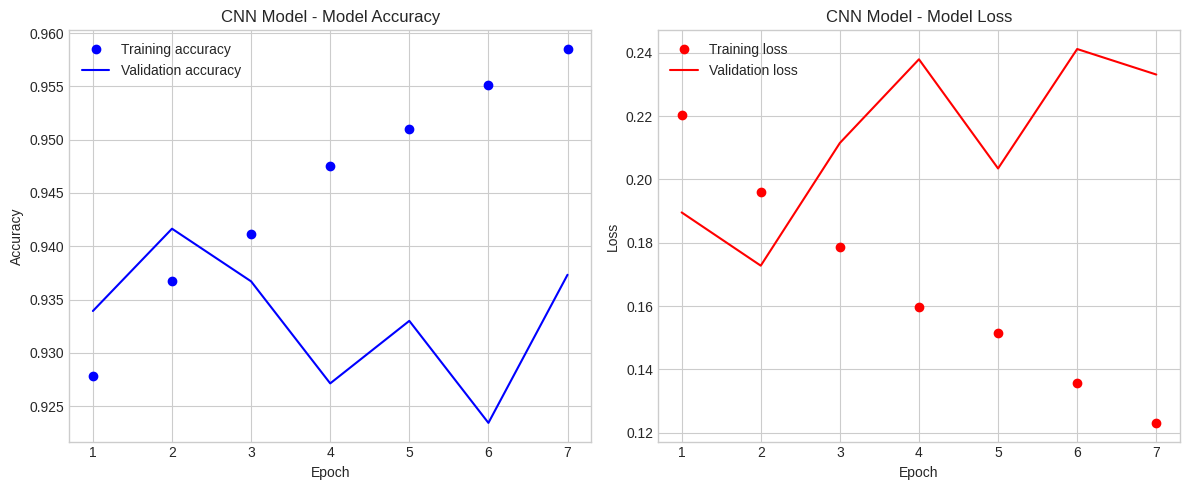

In [ ]:
# Call the function to plot the CNN's history
plot_history(cnn_history_dict, "CNN Model")

These plots confirm our takeaway. The Model Loss plot is the most telling:
- The Training loss (red dots) steadily declines as the model memorizes the training data.
- The Validation loss (red line) hits its lowest point at Epoch 2 and then shoots up, showing classic signs of overfitting.

This confirms `EarlyStopping` did its job by saving the best model from Epoch 2.

We now have two trained models. The real comparison happens on the validation data. Let's build a scorecard to see where we stand.

In [ ]:
import pandas as pd

# Create a dictionary with your VALIDATION results
results = {
    'Model': ['Baseline DNN', 'CNN (Version 1)'],
    'Val. Accuracy': [0.8873, 0.9416], # From Epoch 5 (DNN) and Epoch 2 (CNN)
    'Val. Loss': [0.2922, 0.1728]     # From Epoch 5 (DNN) and Epoch 2 (CNN)
}

# Create and display the DataFrame
scorecard = pd.DataFrame(results)
display(scorecard)

,Model,Val. Accuracy,Val. Loss
0,Baseline DNN,0.8873,0.2922
1,CNN (Version 1),0.9416,0.1728


What a great start! The CNN (Version 1) is the clear winner so far, beating the baseline by a significant margin.

But the plots showed it started overfitting almost immediately. The obvious question that follows is: can we improve on this?

We can try to fight that overfitting with new techniques, like Data Augmentation and Dropout. That's what we're about to find out.

## Boost performance with data augmentation

The most noteworthy issue that emerged while training the first CNN was how quickly the model began to overfit. The best way to combat this is with **data augmentation**.

The idea is intuitive: give the model *more* (varied) data to help it learn more and improve its performance. Data augmentation creates new training exanples on the fly by applying random transformatons, like rotations, shifts, zoome, and flips to each each batch of images.

As a result, the model learns the essential features of fire, rather than simpley memorizing specific images in the dataset. This leads to a more roboust model that better generalizes to unseen data.

In [ ]:
# Create an ImageDataGenerator with augmented settings
# This will ONLY be used for the training set
datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,  # Must match the original split
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Now, create the new augmented training data loader
print("Creating augmented training data generator...")
train_data_aug = datagen_augmented.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)
print("Done.")

Creating augmented training data generator...
Found 29159 images belonging to 3 classes.
Done.


Now that that augmented data has been created, it's time to re-build and compile the model.

In [ ]:
# Note: This is the same architecture as the first CNN we built
cnn_augmented = Sequential([

    # Build the first convolutional layer
    Conv2D(32, (3, 3), input_shape=(64, 64, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Build the second convolutional layer
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Add the final layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
cnn_augmented.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Check the model summary
cnn_augmented.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,923 (6.20 MB)

 Trainable params: 1,625,731 (6.20 MB)

 Non-trainable params: 192 (768.00 B)

Just as we'd expect, the model looks the exact same (because it is!). The key difference here, of course, is that we are about to train the model on the augmented dataset.

In [ ]:
import os
import numpy as np
from keras.models import load_model
from keras.callbacks import EarlyStopping

# --- Define file paths for this AUGMENTED CNN model ---
model_path = "/content/drive/MyDrive/cnn_augmented_model.keras"
history_path = "/content/drive/MyDrive/cnn_augmented_history.npy"

# --- Check if model is already trained ---
if not os.path.exists(model_path):
    print("--- Training CNN w/ Augmentation (file not found) ---")

    # Define the Early Stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    # Note: We use train_data_aug and the ORIGINAL val_data
    history_augmented = cnn_augmented.fit(
        train_data_aug,
        epochs=50,
        validation_data=val_data,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the newly trained model and its history
    print("--- Saving Augmented CNN Model and History ---")
    cnn_augmented.save(model_path)
    np.save(history_path, history_augmented.history)

    # Store history for this session
    cnn_aug_history_dict = history_augmented.history

else:
    # --- If file EXISTS, load the model instead of training ---
    print("--- Loading Augmented CNN Model (already trained) ---")
    cnn_augmented = load_model(model_path)
    cnn_aug_history_dict = np.load(history_path, allow_pickle=True).item()

print("Augmented CNN model is loaded and ready.")

--- Training CNN w/ Augmentation (file not found) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 233s 252ms/step - accuracy: 0.7875 - loss: 0.6819 - val_accuracy: 0.9055 - val_loss: 0.2781
Epoch 2/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 218s 239ms/step - accuracy: 0.8666 - loss: 0.3810 - val_accuracy: 0.8077 - val_loss: 0.8532
Epoch 3/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 217s 238ms/step - accuracy: 0.8872 - loss: 0.3381 - val_accuracy: 0.8898 - val_loss: 0.2793
Epoch 4/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 221s 242ms/step - accuracy: 0.8930 - loss: 0.3124 - val_accuracy: 0.8960 - val_loss: 0.2891
Epoch 5/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 220s 242ms/step - accuracy: 0.8999 - loss: 0.2937 - val_accuracy: 0.9293 - val_loss: 0.2178
Epoch 6/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 219s 240ms/step - accuracy: 0.9093 - loss: 0.2763 - val_accuracy: 0.8882 - val_loss: 0.3262
Epoch 7/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 217s 238ms/step - accuracy: 0.9133 - loss: 0.2634 - val_accuracy: 0.8997 - val_loss: 0.2828
Epoch 8/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 220s 241ms/step - accuracy: 0.9203 -

**Initial takeaway**: There are no silver bullets.

As we predicted, the training with augmented data was much noisier.The model struggled to find its footing, with the validation loss bouncing around.

It ultimately achieved its best performance at Epoch 5, with a validation loss of 0.2178 and validation accuracy of 92.9%.

After that, it couldn't find a better result, and `EarlyStopping` correctly halted the training 5 epochs later.

Interestingly, this score is worse than our first CNN (which hit 0.1728 val_loss and 94.2% val_accuracy). This suggests data augmentation alone wasn't the right fix and may have been too aggressive.

Here's a quick look at our updated scorecard:

In [ ]:
# Create a dictionary with all validation results so far
results = {
    'Model': [
        'Baseline DNN',
        'CNN (V1)',
        'CNN (V2 - w/ Augmentation)'
    ],
    'Val. Accuracy': [
        0.8873,  # Baseline DNN
        0.9416,  # CNN (V1)
        0.9293   # CNN (V2 - w/ Aug)
    ],
    'Val. Loss': [
        0.2922,  # Baseline DNN
        0.1728,  # CNN (V1)
        0.2178   # CNN (V2 - w/ Aug)
    ]
}

# Create and display the DataFrame
scorecard = pd.DataFrame(results)
print("--- Updated Model Scorecard ---")
display(scorecard.sort_values(by='Val. Loss', ascending=True))

--- Updated Model Scorecard ---


,Model,Val. Accuracy,Val. Loss
1,CNN (V1),0.9416,0.1728
2,CNN (V2 - w/ Augmentation),0.9293,0.2178
0,Baseline DNN,0.8873,0.2922


Before wrapping up this notebook, we'll take one more crack at taming this overfitting issue.

## Deploy Dropput to tame overfitting

For our final model architecture, we'll grab the original CNN that we built (the one that scored 94.16% accuracy on the validation set) and ramp up the Dropout.

After all, there is a famous research paper titled: [*Dropout: A Simple Way to Prevent Neural Networks from Overfitting*](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf).

In our earlier CNN we only had a **single round of Dropout**. Here, we expand that to **three rounds**:  
- One after the first convolutional block (Dropout 0.25)  
- Another after the second convolutional block (Dropout 0.25)  
- And finally, a much **stronger Dropout (0.5)** after the fully connected Dense layer  

The logic is simple: convolutional layers have relatively few parameters. Dense layers, on the other hand, have a ton -- over 1.6 million in our case. As a result, they are the biggest soures of overfitting.

Now let's build the Droput model!

In [ ]:
# Initialize the new model
cnn_dropout = Sequential()

# Note: We are now adding multiple rounds of Dropout
cnn_dropout.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn_dropout.add(BatchNormalization())
cnn_dropout.add(Activation('relu'))
cnn_dropout.add(MaxPooling2D(pool_size=(2, 2)))
# Add the first round of Dropout
cnn_dropout.add(Dropout(0.25))

# Build the second convolutional layer, again with Dropout
cnn_dropout.add(Conv2D(64, (3, 3)))
cnn_dropout.add(BatchNormalization())
cnn_dropout.add(Activation('relu'))
cnn_dropout.add(MaxPooling2D(pool_size=(2, 2)))
cnn_dropout.add(Dropout(0.25))

# Add a flattening layer
cnn_dropout.add(Flatten())

# Add the dense, or fully connected layer, and increase the Dropout rate
# Important note: Because dense layers have the most parameters, they are the biggest
# source of overfitting -- hence the increased rate!
cnn_dropout.add(Dense(128, activation='relu'))
cnn_dropout.add(Dropout(0.5))

# Add the output layer
cnn_dropout.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
cnn_dropout.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Check the model summary
cnn_dropout.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,923 (6.20 MB)

 Trainable params: 1,625,731 (6.20 MB)

 Non-trainable params: 192 (768.00 B)

And now, let's train the model.

In [ ]:
# Start with the imports
import os
import numpy as np
from keras.models import load_model
from keras.callbacks import EarlyStopping

# Define file paths for this final DROPOUT CNN model
model_path = "/content/drive/MyDrive/cnn_dropout_model.keras"
history_path = "/content/drive/MyDrive/cnn_dropout_history.npy"

# Check if model is already trained
if not os.path.exists(model_path):
    print("--- Training CNN w/ Dropout (file not found) ---")

    # Define the Early Stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    # Note: We are back to the ORIGINAL train_data
    history_dropout = cnn_dropout.fit(
        train_data,
        epochs=50,
        validation_data=val_data,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the newly trained model and its history
    print("--- Saving Dropout CNN Model and History ---")
    cnn_dropout.save(model_path)
    np.save(history_path, history_dropout.history)

    # Store history for this session
    cnn_dropout_history_dict = history_dropout.history

else:
    # --- If file EXISTS, load the model instead of training ---
    print("--- Loading Dropout CNN Model (already trained) ---")
    cnn_dropout = load_model(model_path)
    cnn_dropout_history_dict = np.load(history_path, allow_pickle=True).item()

print("Dropout CNN model is loaded and ready.")

--- Training CNN w/ Dropout (file not found) ---
Epoch 1/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 201s 214ms/step - accuracy: 0.8074 - loss: 0.9460 - val_accuracy: 0.9151 - val_loss: 0.2578
Epoch 2/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 189s 207ms/step - accuracy: 0.8912 - loss: 0.3060 - val_accuracy: 0.9200 - val_loss: 0.2426
Epoch 3/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 187s 205ms/step - accuracy: 0.9034 - loss: 0.2696 - val_accuracy: 0.9293 - val_loss: 0.1938
Epoch 4/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 185s 202ms/step - accuracy: 0.9159 - loss: 0.2432 - val_accuracy: 0.9120 - val_loss: 0.2656
Epoch 5/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 187s 205ms/step - accuracy: 0.9238 - loss: 0.2198 - val_accuracy: 0.9327 - val_loss: 0.1981
Epoch 6/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 186s 204ms/step - accuracy: 0.9341 - loss: 0.1962 - val_accuracy: 0.9176 - val_loss: 0.2355
Epoch 7/50
912/912 ━━━━━━━━━━━━━━━━━━━━ 185s 203ms/step - accuracy: 0.9378 - loss: 0.1853 - val_accuracy: 0.9361 - val_loss: 0.1802
Epoch 8/50
912/912 ━━━━━━━━

### Final takeaway: The Champion

The strategic application of Dropout was a success. After a long, noisy fight, the model achieved its best generalization at Epoch 12, setting a new high water mark for the project with a **validation loss of 0.1485**.

Let's update our final scorecard:

In [ ]:
import pandas as pd

# Final Validation Results from ALL models
results = {
    'Model': [
        'Baseline DNN',
        'CNN (V1)',
        'CNN (V2 - w/ Augmentation)',
        'CNN (V3 - w/ Dropout) 👑'
    ],
    'Val. Accuracy': [
        0.8873,  # Baseline DNN
        0.9416,  # CNN (V1)
        0.9293,  # CNN (V2 - w/ Aug)
        0.9512   # CNN (V3 - w/ Dropout) <-- CHAMPION ACCURACY
    ],
    'Val. Loss': [
        0.2922,  # Baseline DNN
        0.1728,  # CNN (V1)
        0.2178,  # CNN (V2 - w/ Aug)
        0.1485   # CNN (V3 - w/ Dropout) <-- CHAMPION LOSS
    ]
}

scorecard = pd.DataFrame(results)
print("--- FINAL VALIDATION SCORECARD ---")
# Note: Sorting by Validation Loss confirms the champion
display(scorecard.sort_values(by='Val. Loss', ascending=True))

--- FINAL VALIDATION SCORECARD ---


,Model,Val. Accuracy,Val. Loss
3,CNN (V3 - w/ Dropout) 👑,0.9512,0.1485
1,CNN (V1),0.9416,0.1728
2,CNN (V2 - w/ Augmentation),0.9293,0.2178
0,Baseline DNN,0.8873,0.2922


## Evaluate the best model on the test set

Now to see how our best model generalizes to unseen data -- the test set.

In [ ]:
# The cnn_dropout model object holds the best weights from Epoch 12

print("--- FINAL EVALUATION ON UNSEEN TEST SET ---")
print("Evaluating CNN w/ Dropout (CHAMPION)...")

# Evaluate the champion model on the test data -- test_data was loaded early on
test_score = cnn_dropout.evaluate(test_data, verbose=1)

print(f"\nFinal Test Loss: {test_score[0]:.4f}")
print(f"Final Test Accuracy: {test_score[1]:.4f}")

--- FINAL EVALUATION ON UNSEEN TEST SET ---
Evaluating CNN w/ Dropout (CHAMPION)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 83s 252ms/step - accuracy: 0.9578 - loss: 0.1146

Final Test Loss: 0.1299
Final Test Accuracy: 0.9530


### Final Takeaways

Our champion model, CNN with Dropout, successfully used three rounds of strategic Dropout (after each convolutional block at 0.25, and a stronger 0.5 after the dense layer).

This proved to be the best-performing architecture, achieving a final **Test Accuracy of 95.30%** and a **Test Loss of 0.1299%** on the unseen test set. Dropout helped tame the severe overfitting seen in previous versions while allowing the model to learn powerful, generalizable features.

**Next up?** Given the model's excellent performance on this dataset, the current architecture is a highly effective, production-ready solution. Future work would involve exploring transfer learning (such as using a pre-trained model like MobileNetV3) only to potentially squeeze out the last few tenths of a percent of accuracy, or to tackle a much larger, high-resolution dataset.